dataset link : https://ai.stanford.edu/~amaas/data/sentiment/

About this file
Large Movie Review Dataset v1.0

#### Overview

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

Dataset

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning.

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels. In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.

In [4]:
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings('ignore')

parent_directory = 'F:\\Aegis\\Python\\Jupyter Notebook\\Projects\\Sentiment Analysis\\aclImdb'

### 1 . Import the files

In [17]:
train_pos = parent_directory+'\\train\\pos'
train_neg = parent_directory+'\\train\\neg'
test_pos = parent_directory+'\\train\\pos'
test_neg = parent_directory+'\\train\\neg'

In [18]:
positiveReviews, negativeReviews, testReviewsPositive, testReviewsNegative = [], [], [], []

for file in os.listdir(train_pos):
    f = open(train_pos+'\\'+file, encoding="latin1")
    positiveReviews.append(f.read())
    
for file in os.listdir(train_neg):
    f = open(train_neg+'\\'+file, encoding="latin1")
    negativeReviews.append(f.read())
    
for file in os.listdir(test_pos):
    f = open(test_pos+'\\'+file, encoding="latin1")
    testReviewsPositive.append(f.read())
    
for file in os.listdir(test_neg):
    f = open(test_neg+'\\'+file, encoding="latin1")
    testReviewsNegative.append(f.read())

In [19]:
print(len(positiveReviews))
print(len(negativeReviews))
print(len(testReviewsPositive))
print(len(testReviewsNegative))

12500
12500
12500
12500


In [36]:
positiveReviews[5]

"This isn't the comedic Robin Williams, nor is it the quirky/insane Robin Williams of recent thriller fame. This is a hybrid of the classic drama without over-dramatization, mixed with Robin's new love of the thriller. But this isn't a thriller, per se. This is more a mystery/suspense vehicle through which Williams attempts to locate a sick boy and his keeper.<br /><br />Also starring Sandra Oh and Rory Culkin, this Suspense Drama plays pretty much like a news report, until William's character gets close to achieving his goal.<br /><br />I must say that I was highly entertained, though this movie fails to teach, guide, inspect, or amuse. It felt more like I was watching a guy (Williams), as he was actually performing the actions, from a third person perspective. In other words, it felt real, and I was able to subscribe to the premise of the story.<br /><br />All in all, it's worth a watch, though it's definitely not Friday/Saturday night fare.<br /><br />It rates a 7.7/10 from...<br />

In [27]:
reviews_train = pd.concat([
        pd.DataFrame({"Review":positiveReviews,"Label":1}),
        pd.DataFrame({"Review":negativeReviews,"Label":0})
        ],ignore_index=True)
reviews_test = pd.concat([
        pd.DataFrame({"Review":testReviewsPositive,"Label":1}),
        pd.DataFrame({"Review":testReviewsNegative,"Label":0})
        ],ignore_index=True) 

In [28]:
reviews_train.tail()

,Label,Review
24995,0,"Towards the end of the movie, I felt it was to..."
24996,0,This is the kind of movie that my enemies cont...
24997,0,I saw 'Descent' last night at the Stockholm Fi...
24998,0,Some films that you pick up for a pound turn o...
24999,0,"This is one of the dumbest films, I've ever se..."


In [32]:
print(reviews_train.isnull().sum())
print(reviews_test.isnull().sum())

Label     0
Review    0
dtype: int64
Label     0
Review    0
dtype: int64


### 2 . Preprocessing

In [213]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#nltk.download('wordnet')
import string

from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

stopwords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


#python -m textblob.download_corpora
# https://www.clips.uantwerpen.be/pages/mbsp-tags


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [283]:
def remove_special_chars(review):
    '''Removes special characters excluding , and .'''
    review = BeautifulSoup(review)
    review = review.get_text()
    review = re.sub(r'<br />', ' ', review)
    review = re.sub(r'https?:\/\/.*[\r\n]*', '', review, flags=re.MULTILINE)
    review = re.sub(r'[_"\-%()|+&=*%:$@\[\]/]', ' ', review) #,.!;?'
    return review

#Creating new review of negated sentence
def check_for_negation(review):   
    '''Returns a list of sentences in the review with negation if any'''
    new_review = []
    review_sentences = nltk.sent_tokenize(review)
    for line in review_sentences:
        if re.search("n't",line): #can be further refined using nor
            to_negate_sent = line[line.find("n't")+4:line.find(",")] 
            negated_sent = ""
            complete_sent = ""
            for word in to_negate_sent.split():
                if word in stopwords:
                    negated_sent = negated_sent+word+" "
                else:
                    negated_sent = negated_sent+'NOT_'+word+" "   
            complete_sent = line[:line.find("n't")+4]+negated_sent+line[line.find(","):]
            new_review.append(complete_sent)  
        else:
            new_review.append(line)
    return new_review

def extract_ner_perform_spellcheck(new_review):
    '''Extracts NERs and NON NER words and performs spell check on NON NER words also does Lemmatization'''
    blob = TextBlob(str(new_review))
    ner = []
    non_ner = ""
    puncs = set(string.punctuation)

    #Extracting NER first 
    for word, tag in blob.tags: 
        if tag == 'NNP':
            ner.append(word.upper())
        else:
            non_ner = non_ner+word+" "
    non_ner = re.sub(r"[_'\-%()|+.&=*%:$@\[\]/]", " ", non_ner) #Remove special characters

    #Running spell check
    non_ner_corrected = []
    non_ner_blob = TextBlob(str(non_ner)) #you need to pass a string of sentences to TextBlob and hence non_ner is a string not a list of words
    non_ner_blob = non_ner_blob.correct() #correct the words 
    non_ner_blob_cr = TextBlob(str(non_ner_blob)) #create a blob object for getting the tags

    # Extract only Adjectives, Adverbs, Nound and Verbs
    # Lemmatisation is Faster than Stemmer, end result is a real word unlike stemmer
    for word, tag in non_ner_blob_cr.tags: #number not handled
            if word not in stopwords and (tag.startswith("JJ") or tag.startswith("NN") or tag.startswith("R") or tag.startswith("V")):
                if len(word)<3: #word.isalpha() 
                    continue
                word = lemmatizer.lemmatize(word)
                if tag.startswith("V"):
                    word = lemmatizer.lemmatize(word,pos="v")
                if tag.startswith("R"):
                    word = lemmatizer.lemmatize(word,pos="r")
                if tag.startswith("J"):
                    word = lemmatizer.lemmatize(word,pos="a")
                word = word.lower()
                non_ner_corrected.append(word)
    all_words = non_ner_corrected+ner
    all_words  = re.sub("[^a-zA-Z]"," ",str(all_words))
    return all_words



In [275]:
df_train = reviews_train.sample(frac=1, axis=0).reset_index(drop=True)
df_train.head(10)

,Label,Review,Bag_Of_Words,Review_Length
0,0,Steve Martin should quit trying to do remakes ...,NaN,1125
1,0,"""Unhinged"" is one strange little film, a forgo...",NaN,2006
2,0,The film is almost laughable with Debbie Reyno...,NaN,1164
3,0,the intention the directors has for this films...,NaN,890
4,1,From the beginning of the show Carmen was ther...,NaN,610
5,1,Had fun watching this film.. despite the feeli...,NaN,487
6,1,'Deliverance' is a brilliant condensed epic of...,NaN,4132
7,1,The lovely Danish actress Sonja Richter steals...,NaN,1186
8,1,I've been watching this every night on VH1 thi...,NaN,932
9,1,Being that this movie has a lot of fine entert...,NaN,409


In [320]:
import datetime
print("Start of Cleaning Train Reviews ",datetime.datetime.now())
for index,row in df_train.iterrows():
    if index == 3000:
        break
    if index%200 == 0:
        print(index)
    review = df_train.loc[index,'Review']
    clean_review = remove_special_chars(review)
    new_review = check_for_negation(clean_review)
    bag_of_words = extract_ner_perform_spellcheck(new_review)
    df_train.loc[index,'Bag_Of_Words'] = bag_of_words
print("End of Cleaning Train Reviews ",datetime.datetime.now())

Start of Cleaning Train Reviews  2019-05-10 21:26:01.326352
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
End of Cleaning Train Reviews  2019-05-11 00:06:29.984803


In [321]:
df_train.to_csv("df_train.csv",index=False)

In [322]:
df_train.head()

,Label,Review,Bag_Of_Words,Review_Length
0,0,Steve Martin should quit trying to do remakes ...,steve quit try remarked classic ...,1125
1,0,"""Unhinged"" is one strange little film, a forgo...",unhinged strange little film for...,2006
2,0,The film is almost laughable with Debbie Reyno...,film almost laughable tear mothe...,1164
3,0,the intention the directors has for this films...,intention director film quite ho...,890
4,1,From the beginning of the show Carmen was ther...,beginning show best character ge...,610


## 3. Exploratory Data Analysis

In [222]:
reviews_train['Review_Length'] = reviews_train['Review'].apply(len)

In [344]:
df = df_train.loc[0:2999,:]

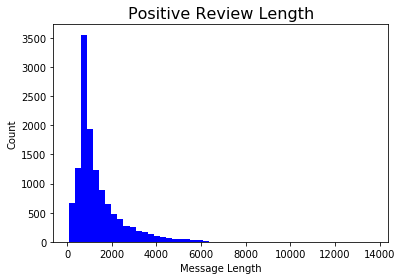

In [224]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting length of Review text for Positive Review
plt.hist(reviews_train[reviews_train['Label']==1]['Review_Length'],color='blue',bins=50)
plt.title('Positive Review Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

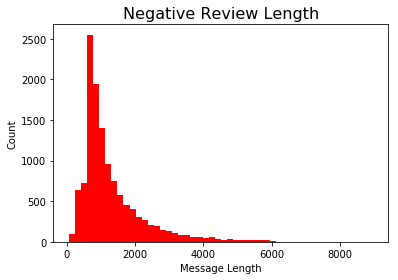

In [225]:
# Plotting length of Review text for Negative Review
plt.hist(reviews_train[reviews_train['Label']==0]['Review_Length'],color='red',bins=50)
plt.title('Negative Review Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

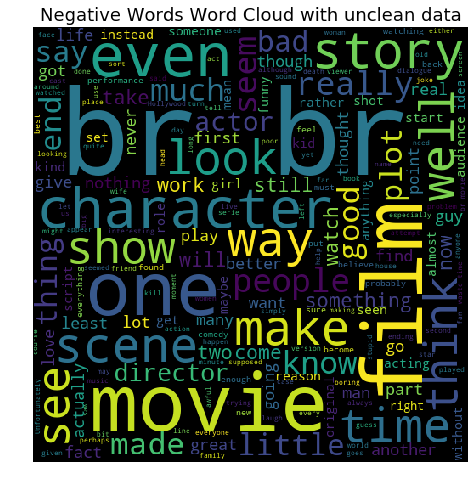

In [406]:
from wordcloud import WordCloud

negative_words = ' '.join(list(reviews_train[reviews_train['Label'] == 0]['Review']))
neg_wc = WordCloud(width=512,height=512).generate(negative_words)
plt.figure(figsize=(15,8))
plt.imshow(neg_wc)
plt.axis("off")
plt.title("Negative Words Word Cloud with unclean data",fontsize=18)
plt.show()

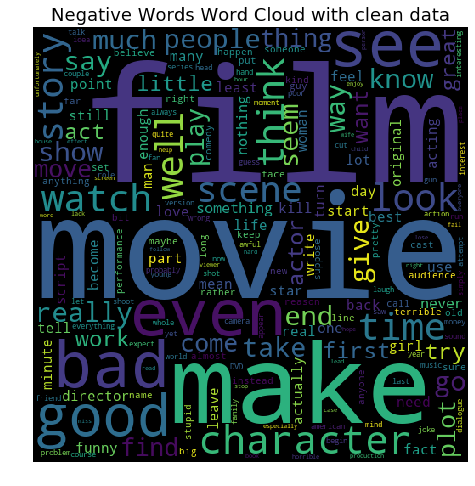

In [407]:
negative_words = ' '.join(list(df[df['Label'] == 0]['Bag_Of_Words']))
neg_wc = WordCloud(width=512,height=512).generate(negative_words)
plt.figure(figsize=(15,8))
plt.imshow(neg_wc)
plt.axis("off")
plt.title("Negative Words Word Cloud with clean data",fontsize=18)
plt.show()

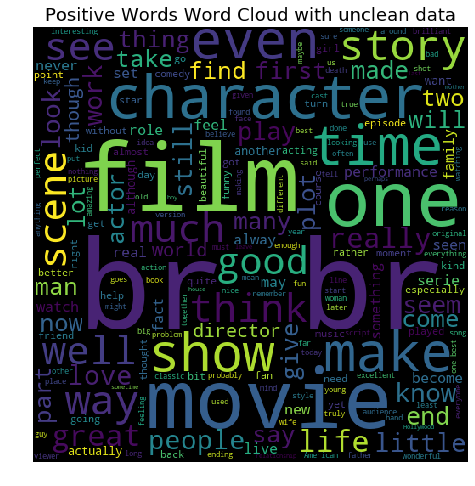

In [405]:
positive_words = ' '.join(list(reviews_train[reviews_train['Label'] == 1]['Review']))
pos_wc = WordCloud(width=512,height=512).generate(positive_words)
plt.figure(figsize=(15,8))
plt.imshow(pos_wc)
plt.axis("off")
plt.title("Positive Words Word Cloud with unclean data",fontsize=18)
plt.show()

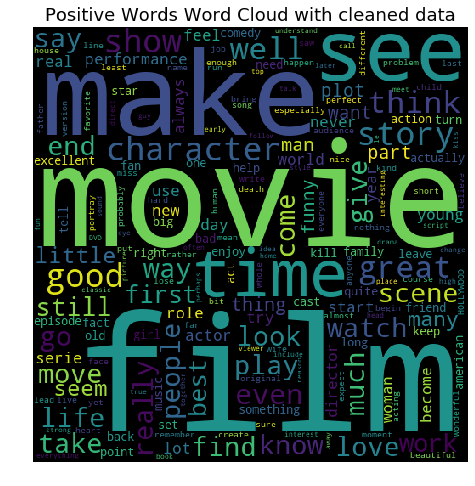

In [404]:
positive_words = ' '.join(list(df[df['Label'] == 1]['Bag_Of_Words']))
pos_wc = WordCloud(width=512,height=512).generate(positive_words)
plt.figure(figsize=(15,8))
plt.imshow(pos_wc)
plt.axis("off")
plt.title("Positive Words Word Cloud with cleaned data",fontsize=18)
plt.show()

## 4. Model Building

### 4.1 TF-IDF 

####  TF-IDF unigram model

In [347]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='latin-1',analyzer='word',lowercase=False,smooth_idf=True)

In [348]:
#Splitting into train and test dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

In [349]:
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)
print(type(features_train))
pd.DataFrame(features_train.todense(),columns=tfidf.get_feature_names())

<class 'scipy.sparse.csr.csr_matrix'>


,AAA,AAG,AAGE,AANKH,AARDMAN,AARON,ABANAZER,ABBAS,ABBEY,ABBOTT,...,zeppelin,zero,zest,zis,zombiefication,zombiefied,zombies,zone,zum,zwartboek
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [350]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(features_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [351]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
prediction = model.predict(features_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.74
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       449
           1       0.93      0.52      0.67       451

   micro avg       0.74      0.74      0.74       900
   macro avg       0.80      0.74      0.73       900
weighted avg       0.80      0.74      0.73       900



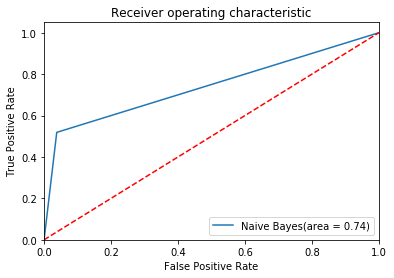

In [352]:
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### TF-IDF bigram model

In [403]:
tfidf = TfidfVectorizer(encoding='latin-1',analyzer='word',lowercase=False,smooth_idf=True,ngram_range=(1,2))

X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)

model = MultinomialNB()
model.fit(features_train,y_train)

prediction = model.predict(features_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score",roc_auc_score(y_test,prediction))

0.6977777777777778
              precision    recall  f1-score   support

           0       0.63      0.98      0.76       449
           1       0.95      0.42      0.58       451

   micro avg       0.70      0.70      0.70       900
   macro avg       0.79      0.70      0.67       900
weighted avg       0.79      0.70      0.67       900

ROC Score 0.6983935723139374


### 4.2 Count Vectorizer

#### 1. Using Uni gram and Gaussian NB

In [379]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

In [380]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=False,max_features=10000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

In [355]:
X_test.shape

(900, 19892)

In [356]:
X_train.shape

(2100, 19892)

In [381]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)

# Predicting Test Results
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.6544444444444445
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       449
           1       0.70      0.53      0.61       451

   micro avg       0.65      0.65      0.65       900
   macro avg       0.66      0.65      0.65       900
weighted avg       0.66      0.65      0.65       900



In [382]:
roc_auc_score(y_test,y_pred)

0.654711875120371

#### 2. Using Uni gram and MultiNomial NB

In [384]:
model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8255555555555556
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       449
           1       0.84      0.80      0.82       451

   micro avg       0.83      0.83      0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900

ROC Score 0.825611484501158


#### 3. Using Bi gram and Gaussian NB

In [397]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

cv = CountVectorizer(lowercase=False,max_features=10000,ngram_range=(1, 2))
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()


In [389]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train,y_train)

# Predicting Test Results
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("ROC Score" ,roc_auc_score(y_test,y_pred))

0.7111111111111111
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       449
           1       0.71      0.72      0.71       451

   micro avg       0.71      0.71      0.71       900
   macro avg       0.71      0.71      0.71       900
weighted avg       0.71      0.71      0.71       900

ROC Score 0.7110948696042942


#### 4. Using Bi gram and Multinomial NB

In [398]:
model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8311111111111111
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       449
           1       0.84      0.82      0.83       451

   micro avg       0.83      0.83      0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900

ROC Score 0.831134968567746


#### 5. Using Tri gram and Multinomial NB

In [401]:
X_train, X_test, y_train, y_test = train_test_split(df['Bag_Of_Words'], df["Label"], test_size = 0.30, random_state = 0)

cv = CountVectorizer(lowercase=False,max_features=10000,ngram_range=(1, 3))
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

model = MultinomialNB()
model.fit(X_train,y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))
print("ROC Score" ,roc_auc_score(y_test,prediction))

0.8366666666666667
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       449
           1       0.84      0.83      0.84       451

   micro avg       0.84      0.84      0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900

ROC Score 0.8366831441142918


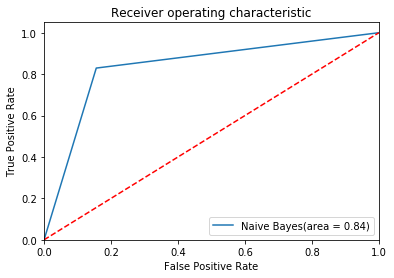

In [402]:
nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machines

In [425]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(lowercase=True,ngram_range=(1,2),max_features=20000)),
                ('clf', LinearSVC(random_state=0)),
            ])


SVC_pipeline.fit(X_train, y_train)
# compute the testing accuracy
prediction = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
print("ROC Score ",roc_auc_score(y_test,prediction))

Test accuracy is 0.8533333333333334
ROC Score  0.8533079175699634


In [418]:
SVC_pipeline.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])>